In [69]:
import os
import glob
import random
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [164]:
# 랜덤 시드 고정
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [165]:
# 데이터 가비지 헤더 제거 및 클로로필 단위 변환 함수
def load_clean_csv(path):
    with open(path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if "날짜 시간" in line:
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"'날짜 시간' 행을 찾을 수 없습니다: {path}")

    df = pd.read_csv(path, skiprows=header_idx)
    df['날짜 시간'] = pd.to_datetime(df['날짜 시간'])
    df['날짜'] = df['날짜 시간'].dt.date

    # ---- 클로로필 관련 열 자동 탐색 ----
    chl_cols = [c for c in df.columns if "Chlorophyll" in c and "농도" in c]

    for col in chl_cols:
        if "(ppb)" in col:
            # ppb → µg/L 변환
            df[col.replace("(ppb)", "(µg/L)")] = df[col]
            df.drop(columns=[col], inplace=True)
            
    return df

In [166]:
# 날짜별 요약 CSV 생성 함수
def summarize_point_folder(point_folder, save_dir):
    """하나의 포인트 폴더 내 모든 날짜 CSV를 불러와 평균 요약"""
    summary_list = []

    for date_folder in sorted(os.listdir(point_folder)):
        date_path = os.path.join(point_folder, date_folder)
        if not os.path.isdir(date_path):
            continue  # 혹시 폴더 아닌게 섞여 있을 수도 있음

        daily_dfs = []

        for file in os.listdir(date_path):
            if not file.endswith(".csv"):
                continue
            file_path = os.path.join(date_path, file)
            try:
                df = load_clean_csv(file_path)
                daily_dfs.append(df)
            except Exception as e:
                print(f"⚠️ {file_path} 로드 실패: {e}")

        if len(daily_dfs) == 0:
            continue

        # 여러 CSV를 concat 후 평균 계산
        daily_df = pd.concat(daily_dfs)
        daily_mean = daily_df.mean(numeric_only=True)
        daily_mean["날짜"] = pd.to_datetime(date_folder, format="%Y%m%d").date()

        summary_list.append(daily_mean)

    # 날짜별 평균이 담긴 DataFrame 생성
    if len(summary_list) > 0:
        summary_df = pd.DataFrame(summary_list)
        summary_df.sort_values("날짜", inplace=True)
        cols = ["날짜"] + [c for c in summary_df.columns if c != "날짜"]
        summary_df = summary_df[cols]
        
        point_name = os.path.basename(point_folder.rstrip("/\\"))
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{point_name}_summary.csv")
        summary_df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"✅ {point_name} 요약 CSV 저장 완료 → {save_path}")
    else:
        print(f"❌ {point_folder} 요약 데이터 없음.")


In [ ]:
# # 폴더에 분산된 데이터 불러오기
# data_dir = "point_data"
# dataset = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
# print(len(dataset))
# print(dataset[0])

In [168]:
# # 샘플 데이터 로드 및 확인
# sample_path = dataset[0]
# df = load_clean_csv(sample_path)

# print("파일 경로:", sample_path)
# print("데이터 shape:", df.shape)
# print("컬럼명:", df.columns.tolist())
# # print(df.head())

In [169]:
# # 데이터셋 분할
# data_num = len(dataset)
# train_dataset, val_dataset, test_dataset = dataset[:int(data_num*0.8)], dataset[int(data_num*0.8):int(data_num*0.9)], dataset[int(data_num*0.9):]
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [170]:
# LSTM 모델 정의
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        input_size: 입력 feature 수
        hidden_size: LSTM hidden 차원
        num_layers: LSTM 층 수
        output_size: 예측값 차원
        """
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: [batch_size, seq_len, input_size]
        """
        out, _ = self.lstm(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]          # 마지막 시점 출력
        out = self.fc(out)           # [batch, output_size]
        return out

In [171]:
# 시계열 데이터셋 클래스
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [172]:
# # 모든 포인트 폴더 요약본 생성
# dataset_root = "point_data"      # 포인트 폴더들이 들어 있는 상위 폴더
# output_dir = "summaries"      # 요약본 저장 폴더
# os.makedirs(output_dir, exist_ok=True)

# for point_folder in sorted(os.listdir(dataset_root)):
#     full_path = os.path.join(dataset_root, point_folder)
#     if os.path.isdir(full_path):
#         summarize_point_folder(full_path, output_dir)

In [ ]:
# 일단위 시계열 데이터 생성
for i in range(1, 6):
    csv_path = "etc"
    csv_name = f"포인트{i}_통합_6_8_10_선택속성_기상병합.csv"
    df = pd.read_csv(f"{csv_path}/{csv_name}")

    # '날짜 시간' 열에서 날짜만 추출 (시간 제거)
    df["날짜"] = pd.to_datetime(df["날짜 시간"]).dt.date

    # 1️⃣ 같은 날짜 평균내기
    df_avg = df.groupby("날짜").mean(numeric_only=True).reset_index()

    # 2️⃣ 같은 날짜 첫 번째 행만 남기기
    df_first = df.groupby("날짜").first().reset_index()

    # CSV 저장
    df_avg.to_csv(f"data/avg_{csv_name}", index=False, encoding='utf-8-sig')
    df_first.to_csv(f"data/fst_{csv_name}", index=False, encoding='utf-8-sig')

print("Done")

Done


In [384]:
# 데이터 불러오기
file_path = "data"
file_name = "fst_포인트5_통합_6_8_10_기상병합"
df = pd.read_csv(f"{file_path}/{file_name}.csv")

# 날짜 제거 (index로 쓰거나 feature에서 제외)
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values('날짜')
try:
    features = df.drop(columns=['날짜', '날짜 시간', 'TM']).values
except:
    features = df.drop(columns=['날짜', 'TM']).values
print("Features shape:", features.shape)
print("First 3 rows:\n", features[:3])

Features shape: (37, 33)
First 3 rows:
 [[ 1.07897560e+00  1.21508720e+00  0.00000000e+00  9.26803060e+05
   9.98380700e-01  7.89807000e-04  7.49845030e+00 -1.90266360e+01
   2.09098790e+02  1.91351740e+01  7.39657830e+00  5.40005060e+00
   4.99545150e+00  3.83974770e+00  4.20314520e+01  5.61988680e+01
   3.26701160e+00  3.26701160e+01  1.72798300e+01  1.00407965e+03
   2.46604820e+01  3.66869898e+01  1.28809965e+02 -9.00000000e+00
  -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 -9.00000000e+00
  -9.00000000e+00 -9.00000000e+00  3.36000000e+00  0.00000000e+00
   2.10000000e+00]
 [ 6.46997030e-01  6.45614200e-01  0.00000000e+00  1.52382120e+06
   9.97046050e-01  4.27540000e-04  7.40209600e+00 -1.38720020e+01
   2.02159100e+02  2.51123330e+01  6.82030500e+00  5.00000900e+00
   4.59323930e+00  3.26563260e+00  4.01558720e+01  5.28333240e+01
   3.27712080e+00  3.27712100e+01  1.72643090e+01  1.00089810e+03
   2.75361770e+01  3.66868773e+01  1.28810173e+02 -9.00000000e+00
  -9.00000000e+00

In [385]:
# 정규화
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Chlorophyll-a 농도 컬럼 인덱스 (features 기준)
chl_flu_idx = 16
chl_nong_idx = 17

# 시퀀스 생성
seq_len = 5
X, y = [], []
for i in range(len(scaled_features) - seq_len):
    X.append(scaled_features[i:i+seq_len])
    next_day = scaled_features[i + seq_len]
    y.append(next_day[[chl_flu_idx, chl_nong_idx]])  # 두 값 예측

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

# 데이터셋 분할
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
print(X_train[0], y_train[0])

# 데이터로더 생성
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=8, shuffle=False)
print(f"train_loader batches: {len(train_loader)}, val_loader batches: {len(val_loader)}, test_loader batches: {len(test_loader)}")

X shape: (32, 5, 33) y shape: (32, 2)
Train size: 25, Val size: 3, Test size: 4
[[5.62411115e-03 7.05392100e-03 0.00000000e+00 5.06513524e-02
  9.79557944e-01 7.05084536e-03 3.83307365e-01 5.05477904e-01
  1.00000000e+00 3.12053998e-02 1.00000000e+00 1.00000000e+00
  1.00000000e+00 3.08725146e-01 2.43963601e-01 2.48206735e-01
  3.65996409e-02 2.71130860e-01 1.00000000e+00 1.00000000e+00
  9.35200697e-02 4.27989831e-01 5.48918739e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.32692308e-01 0.00000000e+00
  3.93939394e-01]
 [3.37244254e-03 3.74797098e-03 0.00000000e+00 8.34639444e-02
  7.78058760e-01 3.81677856e-03 3.61550040e-01 5.24679101e-01
  9.87510673e-01 2.97854772e-01 8.54684963e-01 8.57019069e-01
  8.58513542e-01 2.62564882e-01 2.33077152e-01 2.33514880e-01
  3.67135749e-02 2.71974902e-01 7.77731634e-01 8.28955454e-01
  1.86237225e-01 3.77993387e-01 7.47165857e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.

In [386]:
# 모델 정의
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 3  # 1: Vanilla LSTM, 2>: Stacked LSTM
output_size = 2
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [387]:
# 모델 학습
num_epochs = 300
best_train_loss = float('inf')
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            preds = model(X_val)
            val_loss += criterion(preds, y_val).item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")\
    
    if val_loss < best_val_loss:
        best_train_loss = total_loss/len(train_loader)
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1

model.load_state_dict(best_model_state)
print(f"✅ {best_epoch} model loaded with Val Loss: {best_val_loss:.6f}")

time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
weight_dir = "weights"
weight_name = f"{time_str}_{file_name}_{best_epoch}epoch.pth"
torch.save(model.state_dict(), f"{weight_dir}/{weight_name}")
print(f"Saved: {weight_dir}/{weight_name}")

Epoch [1/300] Train Loss: 0.238711 | Val Loss: 0.013485
Epoch [2/300] Train Loss: 0.132389 | Val Loss: 0.006915
Epoch [3/300] Train Loss: 0.120088 | Val Loss: 0.006568
Epoch [4/300] Train Loss: 0.118065 | Val Loss: 0.011913
Epoch [5/300] Train Loss: 0.135426 | Val Loss: 0.018129
Epoch [6/300] Train Loss: 0.107839 | Val Loss: 0.027446
Epoch [7/300] Train Loss: 0.105731 | Val Loss: 0.023755
Epoch [8/300] Train Loss: 0.096401 | Val Loss: 0.013526
Epoch [9/300] Train Loss: 0.153857 | Val Loss: 0.011536
Epoch [10/300] Train Loss: 0.115696 | Val Loss: 0.025898
Epoch [11/300] Train Loss: 0.104370 | Val Loss: 0.042602
Epoch [12/300] Train Loss: 0.125825 | Val Loss: 0.015571
Epoch [13/300] Train Loss: 0.053872 | Val Loss: 0.010393
Epoch [14/300] Train Loss: 0.037589 | Val Loss: 0.008410
Epoch [15/300] Train Loss: 0.026881 | Val Loss: 0.011470
Epoch [16/300] Train Loss: 0.023090 | Val Loss: 0.014695
Epoch [17/300] Train Loss: 0.018553 | Val Loss: 0.017918
Epoch [18/300] Train Loss: 0.046159 | Va

MSE per feature → Chl_flu: 0.000383, Chl_nong: 0.017452

=== 마지막 입력 및 예측 결과 ===
입력 시퀀스 (마지막 샘플):
[[2.8639860e-04 2.4434336e-04 0.0000000e+00 1.0000000e+00 0.0000000e+00
  2.4460806e-04 7.4494529e-01 2.4325286e-01 6.1104071e-01 1.0000000e+00
  5.8955455e-01 5.3655720e-01 5.8264810e-01 5.3464091e-01 6.2833881e-01
  6.0879004e-01 2.1139098e-02 1.5659887e-01 2.5533438e-01 1.3890114e-01
  8.3092737e-01 0.0000000e+00 9.6503764e-02 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  8.4615386e-01 6.0000002e-01 3.0303031e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.4932147e-01 2.8701159e-01
  0.0000000e+00 4.6746612e-01 5.2938104e-01 5.4982352e-01 7.7016389e-01
  7.5125635e-01 7.5688940e-01 7.5620764e-01 1.0021014e-01 1.0810825e-01
  1.0955067e-01 2.2604620e-02 1.6745548e-01 3.2772449e-01 1.7960389e-01
  7.9681259e-01 4.7686625e-01 6.4342195e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.000000

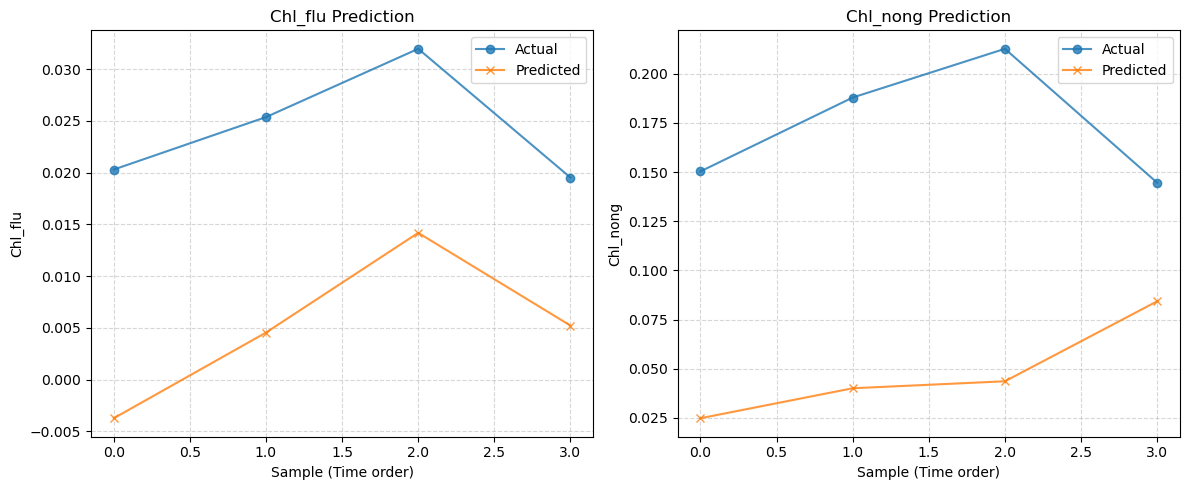

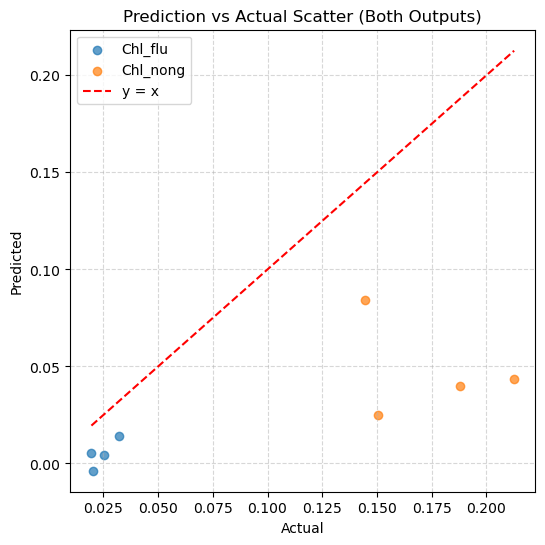

In [388]:
# 테스트 및 평가
model.eval()
all_preds = []
all_labels = []
test_loss = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.float()
        y_test = y_test.float()

        y_preds = model(X_test)
        all_preds.append(y_preds.cpu())
        all_labels.append(y_test.cpu())
        test_loss += criterion(y_preds, y_test).item()

y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = torch.cat(all_labels, dim=0).numpy()

mse_each = ((y_pred - y_true) ** 2).mean(axis=0)
print(f"MSE per feature → Chl_flu: {mse_each[0]:.6f}, Chl_nong: {mse_each[1]:.6f}")

print("\n=== 마지막 입력 및 예측 결과 ===")
print(f"입력 시퀀스 (마지막 샘플):\n{X_test[-1].numpy()}")
print(f"실제값 (y_true): {y_true[-1]}")
print(f"예측값 (y_pred): {y_pred[-1]}")

# Visualization
feature_names = ["Chl_flu", "Chl_nong"]
plt.figure(figsize=(12, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(y_true[:, i], label="Actual", marker='o', alpha=0.8)
    plt.plot(y_pred[:, i], label="Predicted", marker='x', alpha=0.8)
    plt.title(f"{feature_names[i]} Prediction")
    plt.xlabel("Sample (Time order)")
    plt.ylabel(feature_names[i])
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Scatter comparison
plt.figure(figsize=(6,6))
for i in range(2):
    plt.scatter(y_true[:, i], y_pred[:, i], label=feature_names[i], alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="y = x")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Prediction vs Actual Scatter (Both Outputs)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [389]:
# 마지막 샘플 실제값과 예측값 복원
feature_indices = [chl_flu_idx, chl_nong_idx]

dummy_true = np.zeros(scaled_features.shape[1])
dummy_pred = np.zeros(scaled_features.shape[1])
dummy_true[feature_indices] = y_true[-1]  # 스케일된 마지막 실제값
dummy_pred[feature_indices] = y_pred[-1]  # 스케일된 마지막 예측값

# 역변환
y_true_orig = scaler.inverse_transform(dummy_true.reshape(1, -1))[0, feature_indices]
y_pred_orig = scaler.inverse_transform(dummy_pred.reshape(1, -1))[0, feature_indices]
print("\n=== 마지막 입력 및 예측 결과 (원래 단위) ===")
print(f"실제값 (원래 단위): {y_true_orig}")
print(f"예측값 (원래 단위): {y_pred_orig}")


=== 마지막 입력 및 예측 결과 (원래 단위) ===
실제값 (원래 단위): [ 1.75150784 17.51507747]
예측값 (원래 단위): [ 0.48257094 10.29414484]


In [ ]:
# 결과 로그 저장
log_dict = {
    "datetime": time_str,
    "file_name": file_name,
    "best_epoch": best_epoch,
    "train_loss": best_train_loss,
    "val_loss": best_val_loss,
    "test_loss": test_loss,
    "test_mse": np.mean(mse_each),
    "hidden_size": hidden_size,
    "num_layers": num_layers
}
with open('weights/weights_result.csv', mode='a', newline='', encoding='utf-8') as f:
    df_new = pd.DataFrame([log_dict])
    df_new.to_csv('weights/weights_result.csv', mode='a', index=False, header=False, encoding='utf-8')